In [1]:
import pandas as pd
from .simulation_utils import datasets as ds
import numpy as np
%matplotlib inline

In [2]:
def generate_uniform(nusers, nitems, frac):
    # mean of poisson random variable
    pois_lambda = frac * nitems
    # generate consumed items for each user uniformly over all items
    # prevent the number of consumed items from being greater than the total number of items
    items = None
    while not items:
        try:
            # compute the total number of consumed items for each user as a poisson random variable
            item_count = np.random.poisson(pois_lambda, nusers)
            items = map(lambda x : np.random.choice(nitems, size=x, replace=False), item_count)
        except:
            pass
    user_item = map(lambda x : pd.DataFrame({'user': x[0], 'item':x[1]}), zip(range(nusers), items))
    return pd.concat(user_item, axis=0, ignore_index=True)

In [3]:
def fac_mul(x, y, n):
    ret = 1
    for i in range(n - 1):
        ret *= (x + i) / (y + i)
    return ret

In [4]:
def generate_IBPPL(nusers, nitems, frac, c=1, sigma=0):
    from scipy.special import gamma
    
    alpha = nitems * frac
    assert alpha > 0
    assert c > (-sigma), "c must be greater than -sigma"
    assert 0 <= sigma < 1, "sigma must be in [0, 1)"
    # the number of items picked
    nitems_picked = 0
    # the number of users who tried for each item (m_k)
    npicks = np.ones(0, dtype=np.int64)
    # items for each user
    items = []
    for u in range(1, nusers + 1):
        # pick from previously-used items with probability prob. (len(prob) == nitems_used)
        prob = (npicks - sigma) / (u - 1 + c)
        pick = np.random.binomial(1, prob, nitems_picked) > 0
        repicked_items = np.array(range(nitems_picked), dtype=np.int64)[pick]
        # update item pick counts
        npicks[pick] = npicks[pick] + 1
        # pick new items
        if u > 3:
            lam = alpha * gamma(1 + c) * gamma(1 + c + sigma) / (gamma(c + sigma) * gamma(2 + c)) * fac_mul(1+c+sigma, 2+c, u-1)
        else:
            lam = alpha * (gamma(1 + c) / gamma(u + c)) * (gamma(u - 1 + c + sigma) / gamma(c + sigma))
#         lam = alpha * gamma(1 + c) * gamma(u - 1 + c + sigma) / (gamma(u + c) * gamma(c + sigma))
        nnew = np.random.poisson(lam)
        new_items = np.array(range(nitems_picked, nitems_picked + nnew), dtype=np.int64)
        # add new items to picked ones
        if (nnew > 0):
            npicks = np.hstack((npicks, np.ones(nnew, dtype=np.int64)))
            nitems_picked += nnew
            items.append(np.hstack((repicked_items, new_items)))
        else:
            items.append(repicked_items)
    user_item = map(lambda x : pd.DataFrame({'user': x[0], 'item':x[1]}), zip(range(nusers), items))
    return pd.concat(user_item, axis=0, ignore_index=True)

In [5]:
def sample_uniform(ratings, frac):
    ds_col_name = ratings.columns
    ratings.rename(columns={ds_col_name[0]: 'user',
                            ds_col_name[1]: 'item'},
                   inplace=True)
    return ratings.groupby('user').apply(lambda x : x.sample(frac=frac)).reset_index(drop=True)

In [6]:
def sample_popular(ratings, frac):
    col_names = ratings.columns
    ratings.rename(columns={col_names[0]: 'user',
                            col_names[1]: 'item'},
                   inplace=True)
    popularity = ratings[['user', 'item']].groupby('item', as_index=False).count()
    popularity['prob'] = popularity['user'] / popularity['user'].sum()
    popularity.drop('user', axis=1, inplace=True)
    merged = ratings.merge(popularity, on='item', how='left')
    return (merged.groupby('user')
            .apply(lambda x : x.sample(frac=frac, weights='prob'))
            .reset_index(drop=True)
            .drop('prob', axis=1))

In [7]:
def summarize_data_sets(data_funs):
    dataset_stats = []
    ds_user_profile_stats = []
    ds_item_popularity_stats = []
    ds_user_profile = []
    ds_item_popularity = []
    for name, data_fun in data_funs:
        # data stats
        dataset = data_fun()
        ds_col_name = dataset.columns
        dataset.rename(columns={ds_col_name[0]: 'user',
                                ds_col_name[1]: 'item'},
                       inplace=True)
        nusers = len(dataset.iloc[:, 0].unique())
        nitems = len(dataset.iloc[:, 1].unique())
        npairs = len(dataset)
        density = npairs / nitems / nusers
        dataset_stats.append([name, nusers, nitems, npairs, density])
        
        # user profile
        user_profile = dataset.iloc[:, :2].groupby('user', as_index=False).count()
        
        # get user profile size stats and rename the column to dataset name
        user_profile_stats = user_profile['item'].rename(name).describe()
        ds_user_profile_stats.append(user_profile_stats)
        
        # save user profile data for plotting
        user_profile['dataset'] = name
        user_profile.drop('user', axis=1)
        ds_user_profile.append(user_profile)
        
        # item popularity stats
        item_popularity = dataset.iloc[:, :2].groupby('item', as_index=False).count()
        item_popularity_stats = item_popularity['user'].rename(name).describe()
        ds_item_popularity_stats.append(item_popularity_stats)
        
        item_popularity['dataset'] = name
        item_popularity.drop('item', axis=1)
        ds_item_popularity.append(item_popularity)

    df = pd.DataFrame.from_records(dataset_stats, columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)
    
    df = pd.concat(ds_user_profile_stats, axis=1)
    print('user profile stats')
    print(df)
    
    df = pd.concat(ds_item_popularity_stats, axis=1)
    print('item popularity stats')
    print(df)
    
    user_profile_df = pd.concat(ds_user_profile, axis=0, ignore_index=True)
    
    item_popularity_df = pd.concat(ds_item_popularity, axis=0, ignore_index=True)
    count_popularity = (item_popularity_df
                        .groupby(['dataset','user'])
                        .size().reset_index().rename(columns={0:'count'}))
    item_popularity_df['rank'] = item_popularity_df.groupby('dataset')['user'].rank(method='min', ascending=False)
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    g = sns.FacetGrid(user_profile_df, col='dataset', sharey=False, sharex=False, col_wrap=2, height=5)
    g.map(plt.hist, 'item') \
     .set_titles('{col_name}', size=15) \
     .set_axis_labels('user profile size', 'number of users')
    
    g = sns.FacetGrid(item_popularity_df, col='dataset', sharey=False, sharex=False, col_wrap=2, height=5)
    g.map(plt.scatter, 'rank', 'user') \
     .set(xscale='log',yscale='log') \
     .set_titles('{col_name}', size=15) \
     .set_axis_labels('rank', 'popularity')
    
    g = sns.FacetGrid(count_popularity, col='dataset', sharey=False, sharex=False, col_wrap=2, height=5)
    g.map(plt.scatter, 'user', 'count') \
     .set(xscale='log',yscale='log') \
     .set_titles('{col_name}', size=15) \
     .set_axis_labels('popularity', 'count')
    plt.show()

In [8]:
def unif_unif():
    pref = generate_uniform(943, 1682, 0.5)
    obs = sample_uniform(pref, 0.2)
    return obs

In [9]:
def unif_pop():
    pref = generate_uniform(943, 1682, 0.5)
    obs = sample_popular(pref, 0.2)
    return obs

In [10]:
def ibp_unif():
    pref = generate_IBPPL(943, 1682, 0.5)
    obs = sample_uniform(pref, 0.2)
    return obs

In [11]:
def ibp_pop():
    pref = generate_IBPPL(943, 1682, 0.5)
    obs = sample_popular(pref, 0.2)
    return obs

### Compare data generation with real data sets

In [12]:
import inspect

data_funs = inspect.getmembers(ds, inspect.isfunction)

In [13]:
data_funs.extend([(unif_unif.__name__, unif_unif), (unif_pop.__name__, unif_pop),
                  (ibp_unif.__name__, ibp_unif), (ibp_pop.__name__, ibp_pop)])

In [14]:
data_funs

[('ml_100k', <function datasets.ml_100k()>),
 ('unif_unif', <function __main__.unif_unif()>),
 ('unif_pop', <function __main__.unif_pop()>),
 ('ibp_unif', <function __main__.ibp_unif()>),
 ('ibp_pop', <function __main__.ibp_pop()>)]

dataset stats
     dataset  nusers  nitems  npairs   density
0    ml_100k     943    1682  100000  0.063047
1  unif_unif     943    1682  158359  0.099840
2   unif_pop     943    1682  158331  0.099822
3   ibp_unif     943    4907  157200  0.033972
4    ibp_pop     943    2907  165030  0.060201
user profile stats
          ml_100k   unif_unif    unif_pop    ibp_unif     ibp_pop
count  943.000000  943.000000  943.000000  943.000000  943.000000
mean   106.044539  167.931071  167.901379  166.702015  175.005302
std    100.931743    5.810390    5.866692    4.241548    4.296962
min     20.000000  149.000000  151.000000  154.000000  163.000000
25%     33.000000  164.000000  164.000000  164.000000  172.000000
50%     65.000000  168.000000  168.000000  167.000000  175.000000
75%    148.000000  172.000000  172.000000  170.000000  178.000000
max    737.000000  187.000000  186.000000  180.000000  190.000000
item popularity stats
           ml_100k    unif_unif     unif_pop     ibp_unif      ibp_po

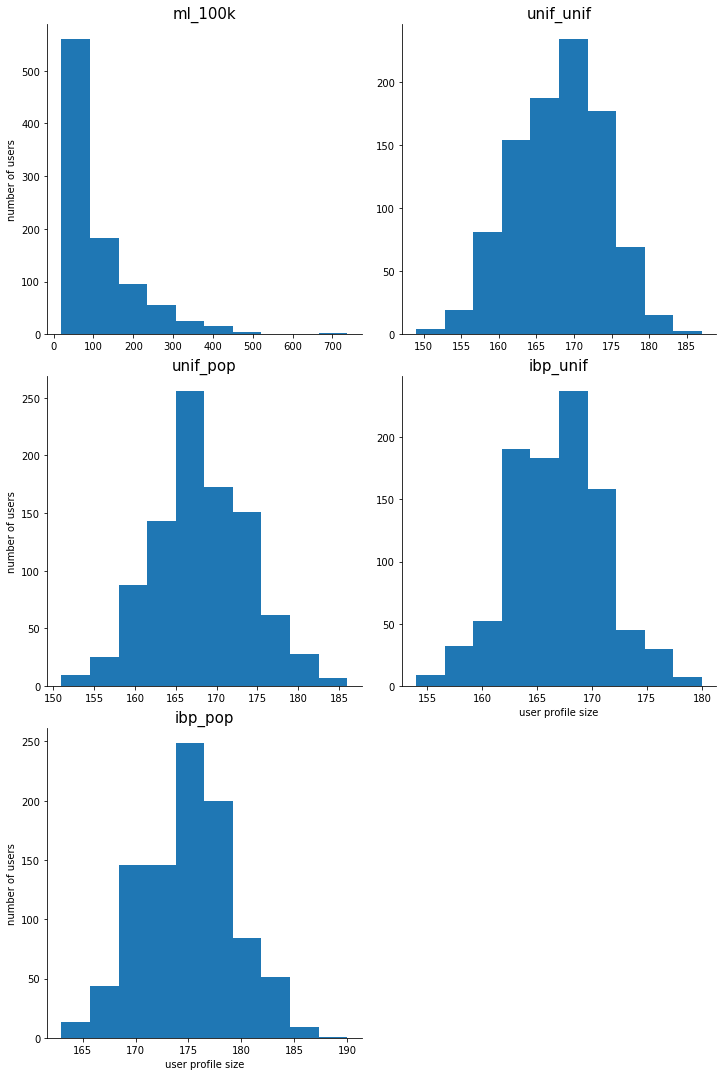

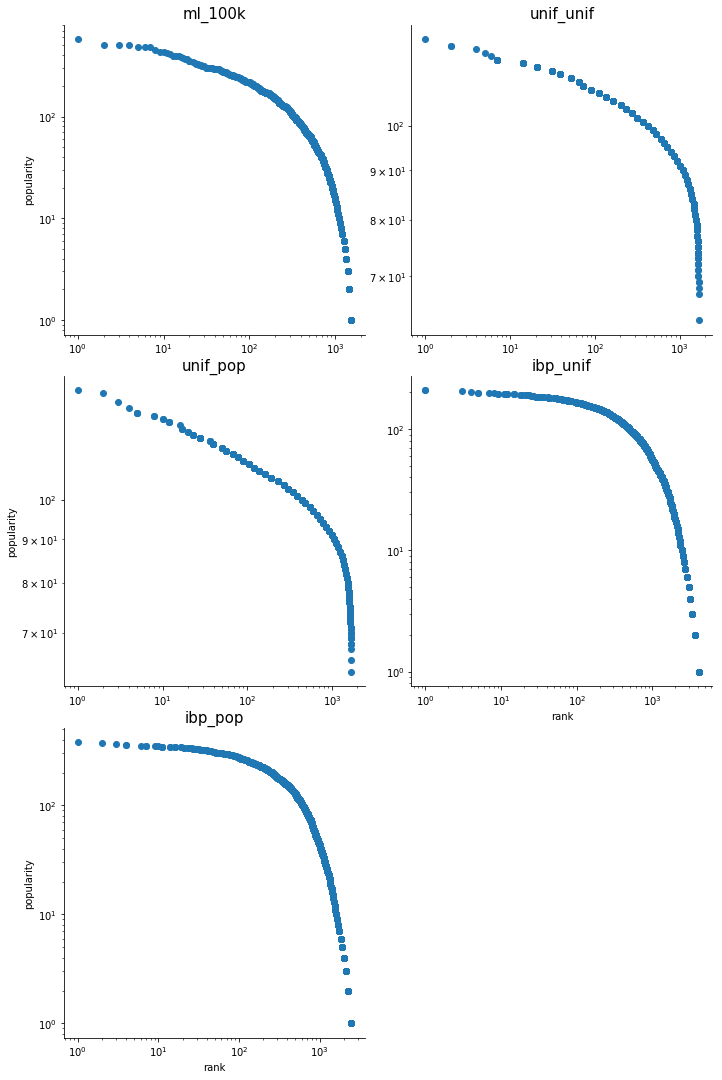

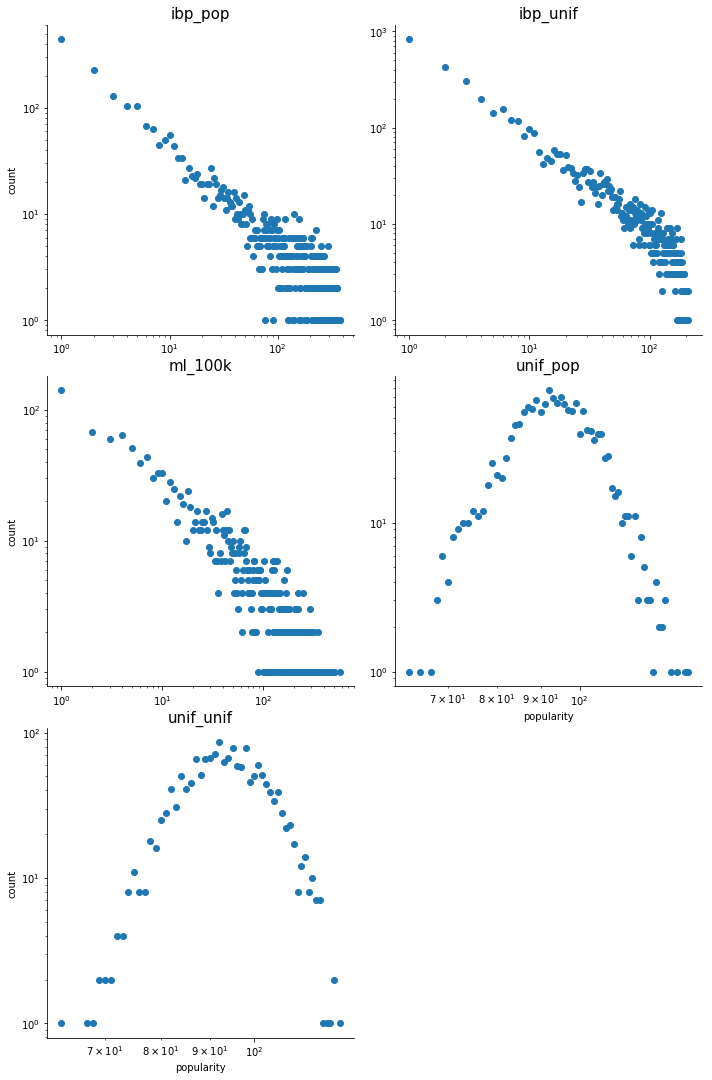

In [15]:
summarize_data_sets(data_funs)

### Experiments

In [16]:
from lenskit import batch, topn
from lenskit import crossfold as xf
from lenskit.algorithms import funksvd

In [17]:
def compute_recall(ratings, recommendations, user_col='user', item_col='item', rating='rating', threshold=0.5):
    rec_user_ratings = recommendations.merge(ratings, how='left', on=[user_col, item_col])
    rec_user_ratings['rel'] = rec_user_ratings[rating] > threshold
    rec_user_rel = rec_user_ratings[[user_col, 'rel']]
    rec_user_tp = rec_user_rel.groupby(user_col, as_index=False).sum()
    user_total_pos = ratings.merge(recommendations[user_col].drop_duplicates().reset_index(drop=True).to_frame(), on=user_col)
    user_total_pos['rel'] = user_total_pos[rating] > threshold
    user_total_pos = user_total_pos[[user_col, 'rel']].groupby(user_col, as_index=False).sum()
    user_recall = rec_user_tp.merge(user_total_pos, on=user_col, suffixes=('_tp', '_total_pos'))
    user_recall['recall'] = user_recall['rel' + '_tp'] / user_recall['rel' + '_total_pos']
    return user_recall['recall'].mean()

In [18]:
pref = generate_IBPPL(943, 1682, 0.5)
pref['rating'] = 1
obs = sample_popular(pref, 0.2)

In [20]:
splits = xf.partition_users(obs, 1, xf.SampleFrac(0.2))
train, test = next(splits)
algo = funksvd.FunkSVD(15, iterations=125, lrate=0.001)
model = algo.train(train)
users = test.user.unique()
recs = batch.recommend(algo, model, users, 20,
        topn.UnratedCandidates(train))

In [22]:
recall_obs = compute_recall(obs, recs)
recall_pref = compute_recall(pref, recs)

In [25]:
algo = funksvd.FunkSVD(15, iterations=125, lrate=0.001)

In [49]:
def run_experiments(generator, sampler, algorithm, times=100):
    obs_metric = []
    pref_metric = []
    for i in range(times):
        pref = generator(943, 1682, 0.5)
        pref['rating'] = 1
        obs = sampler(pref, 0.2)
        splits = xf.partition_users(obs, 1, xf.SampleFrac(0.2))
        train, test = next(splits)
        model = algorithm.train(train)
        users = test.user.unique()
        recs = batch.recommend(algorithm, model, users, 20,
                topn.UnratedCandidates(train))
        # compute metrics
        recall_obs = compute_recall(obs, recs)
        recall_pref = compute_recall(pref, recs)
        obs_metric.append(recall_obs)
        pref_metric.append(recall_pref)
    return obs_metric, pref_metric

In [50]:
def map_fun(x):
    obs, pref = run_experiments(*x)
    return obs[0], pref[0]

In [51]:
def parallel_run(generator, sampler, algorithm, times=100, nthread=8):
    from multiprocessing import Pool
    map_args = [(generator, sampler, algorithm, 1)] * times
    results = None
    with Pool(nthread) as p:
        results = p.map(map_fun, map_args)
    return pd.DataFrame(results, columns=['obs_recall', 'pref_recall'])

In [52]:
results = parallel_run(generate_uniform, sample_uniform, algo)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
results['obs_recall'] = results['obs_recall'].map(lambda x : x[0])
results['pref_recall'] = results['pref_recall'].map(lambda x : x[0])

In [73]:
res_tall = results.melt()

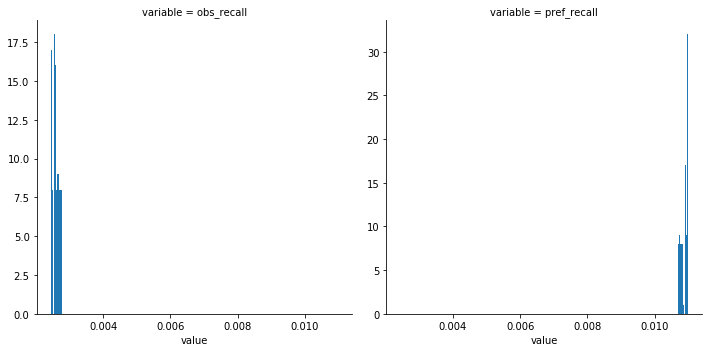

In [75]:
g = sns.FacetGrid(res_tall, col='variable', sharey=False, col_wrap=2, height=5)
g.map(plt.hist, 'value')